# Variational Autoencoders

This notebook is depending on https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder_deconv.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from tensorflow.contrib.distributions import Laplace
from sklearn.metrics import adjusted_rand_score

Using TensorFlow backend.


In [0]:
# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
# number of convolutional filters to use
filters = 64
# convolution kernel size
num_conv = 3
#size of the generated img
digit_size = 28

batch_size = 128

latent_dim = 2
intermediate_dim = 64
epochs = 10

Creating a Variational Autoencoder class, which is parametrized with the distribution components. 
The needed elemnets:


1.   Parameters of the distribution and their activations in the last layer.
2.   The sampling function, which provides the sample from the distribution with given parameters
3.   KL divergence of the given distribution and a predefined distribution. 




In [0]:
class VAE:
  def __init__(self, sampling_function, distribution_params, KLdivergence_function):
    self.sampling_function = sampling_function
    self.distribution_params = distribution_params
    self.KLdivergence_function = KLdivergence_function
    self._get_model()
    
  
  def _get_model(self):
    #create model
    x, hidden = self._encoder()
    distributionVariables=dict()
    for variable in self.distribution_params.keys():
      distributionVariables[variable] = Dense(latent_dim, activation=self.distribution_params[variable])(hidden)
    z = Lambda(self.sampling_function, output_shape=(latent_dim,))(list(distributionVariables.values()))
    out = self._decoder(z)
    
    self.vae = Model(x, out)
  
     # Compute VAE loss
    xent_loss = img_rows * img_cols * metrics.binary_crossentropy(
    K.flatten(x),
    K.flatten(out))
    kl_loss = self.KLdivergence_function(distributionVariables)
    vae_loss = K.mean(xent_loss + kl_loss)
    self.vae.add_loss(vae_loss)
    self.vae.compile(optimizer='rmsprop')
    self.encoder = Model(x,z) 
    
  
    
  def train(self):
    if K.image_data_format() == 'channels_first':
      original_img_size = (img_chns, img_rows, img_cols)
    else:
      original_img_size = (img_rows, img_cols, img_chns)
    # train the VAE on MNIST digits
    (x_train, _), (x_test, y_test) = mnist.load_data()

    x_train = x_train.astype('float32') / 255.
    x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
    x_test = x_test.astype('float32') / 255.
    x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

    self.vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
    
  def generate_img(self, latent_var):
      latent_var = latent_var.reshape(1, len(latent_var))
      x_decoded = self.decoder.predict(latent_var)
      digit = x_decoded[0].reshape(digit_size, digit_size)
      return digit
    
  def get_latent_representation(self, data):
      return self.encoder.predict(data)
       
  
  def _encoder(self):
    if K.image_data_format() == 'channels_first':
      original_img_size = (img_chns, img_rows, img_cols)
    else:
      original_img_size = (img_rows, img_cols, img_chns)
    x = Input(shape=original_img_size)
    conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
    conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
    conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
    conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
    flat = Flatten()(conv_4)
    hidden = Dense(intermediate_dim, activation='relu')(flat)
    return x, hidden
  
  
  def _decoder(self,z):
    # we instantiate these layers separately so as to reuse them later
    decoder_hid = Dense(intermediate_dim, activation='relu')
    decoder_upsample = Dense(filters * 14 * 14, activation='relu')

    if K.image_data_format() == 'channels_first':
      output_shape = (batch_size, filters, 14, 14)
    else:
      output_shape = (batch_size, 14, 14, filters)

    decoder_reshape = Reshape(output_shape[1:])
    decoder_deconv_1 = Conv2DTranspose(filters,
                                     kernel_size=num_conv,
                                     padding='same',
                                     strides=1,
                                     activation='relu')
    decoder_deconv_2 = Conv2DTranspose(filters,
                                     kernel_size=num_conv,
                                     padding='same',
                                     strides=1,
                                     activation='relu')
    if K.image_data_format() == 'channels_first':
      output_shape = (batch_size, filters, 29, 29)
    else:
      output_shape = (batch_size, 29, 29, filters)
    decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                            kernel_size=(3, 3),
                                            strides=(2, 2),
                                            padding='valid',
                                            activation='relu')
    decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')
    
    hid_decoded = decoder_hid(z)
    up_decoded = decoder_upsample(hid_decoded)
    reshape_decoded = decoder_reshape(up_decoded)
    deconv_1_decoded = decoder_deconv_1(reshape_decoded)
    deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
    x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
    x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
    
    #create pure generator
    decoder_input = Input(shape=(latent_dim,))
    _hid_decoded = decoder_hid(decoder_input)
    _up_decoded = decoder_upsample(_hid_decoded)
    _reshape_decoded = decoder_reshape(_up_decoded)
    _deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
    _deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
    _x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
    _x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
    self.decoder = Model(decoder_input, _x_decoded_mean_squash)
    
    return x_decoded_mean_squash

## Normal distribution

The way of these three component is widely known and the original code contains them.

In [4]:
def sampling_normal(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var) * epsilon

normal_params = {'mean': 'linear',
                 'log_var':  'linear'}
def KLdivergence_normal(args):
  z_mean, z_log_var = args['mean'], args['log_var']
  return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

latent_dim = 2
normalVAE = VAE(sampling_normal, normal_params, KLdivergence_normal)
normalVAE.train()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Output "conv2d_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_5" during training.


11493376/11490434 [==============================] - 3s 0us/step
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
44416/60000 [=====================>........] - ETA: 7s - loss: 187.0086

60000/60000 [==============================] - 30s 496us/step - loss: 181.1688 - val_loss: 160.6668
Epoch 2/10
60000/60000 [==============================] - 28s 459us/step - loss: 157.7525 - val_loss: 154.5599
Epoch 3/10
 2304/60000 [>.............................] - ETA: 26s - loss: 152.4505

60000/60000 [==============================] - 28s 467us/step - loss: 152.2437 - val_loss: 150.0215
Epoch 4/10
47232/60000 [======================>.......] - ETA: 5s - loss: 149.5309

60000/60000 [==============================] - 28s 462us/step - loss: 149.2926 - val_loss: 147.5819
Epoch 5/10
60000/60000 [==============================] - 28s 459us/step - loss: 147.2179 - val_loss: 146.1847
Epoch 6/10
 3072/60000 [>.............................] - ETA: 24s - loss: 145.0376

60000/60000 [==============================] - 28s 459us/step - loss: 145.7937 - val_loss: 144.6513
Epoch 7/10
47616/60000 [======================>.......] - ETA: 5s - loss: 144.5792

60000/60000 [==============================] - 28s 460us/step - loss: 144.6056 - val_loss: 145.0626
Epoch 8/10
60000/60000 [==============================] - 28s 463us/step - loss: 143.6867 - val_loss: 143.4367
Epoch 9/10
 3072/60000 [>.............................] - ETA: 25s - loss: 142.4826

60000/60000 [==============================] - 28s 463us/step - loss: 142.8404 - val_loss: 144.2399
Epoch 10/10
47360/60000 [======================>.......] - ETA: 5s - loss: 142.3333

60000/60000 [==============================] - 28s 460us/step - loss: 142.1091 - val_loss: 143.2395


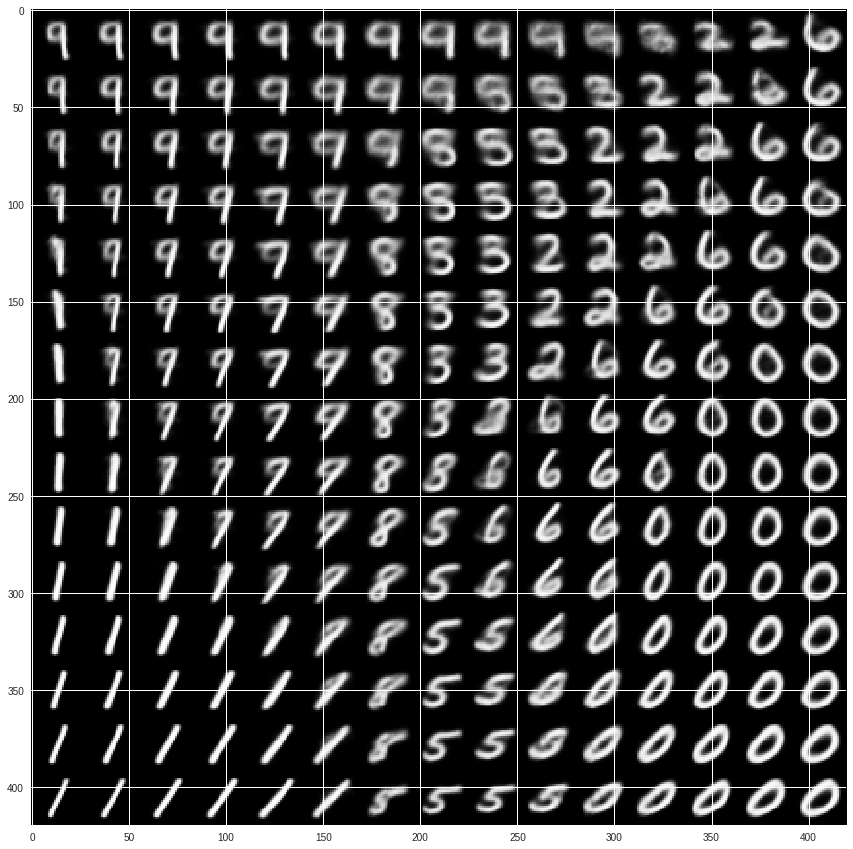

In [5]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([xi, yi])
        digit = normalVAE.generate_img(z_sample)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='Greys_r')
plt.show()



It can be seen theese samples are blurry, this mistake of the VAEs are well known.

## Laplace distribution


Idea: what happens, if a different continous distribution is used...

The main problem is KL divergence of the Laplace distribution is not well known (for me). Wolfram Alpha's integral calculaton capabilities let me down, I couldn't determine the analytical form:(

Idea2: Let's Lapplace approximate the distribution with a normal destribution.
Need:


1.   Expected value of laplace: it is the mu parameter
2.   Second order derivate of the Laplace, for estimate the vaiance of the normal... However the second order gradient is 0

The second part can be problematic, so I approximate it with epsilon sqrt(variance), which is small. From here it is straightforward, use the same KL divergence calculation as in the previous part, but with much smaller variance.  

In conclusion, the approximation is approximated... 


In [6]:
def sampling_laplace(args):
    z_mean, z_log_b = args
    eps = Laplace(loc = 0.0, scale = 1.0).sample()
    return z_mean + eps * K.exp(z_log_b)


laplace_params = {'mean': 'linear',
                 'log_b':  'linear'}
def KLdivergence_laplace(args):
  z_mean, z_log_var = args['mean'], args['log_b']
  eps=0.001
  return  z_log_var - K.log(eps)+(K.square(z_mean) + K.square(eps)) / (K.exp(z_log_var)) - 0.5

latent_dim = 2
laplaceVAE = VAE(sampling_laplace, laplace_params, KLdivergence_laplace)
laplaceVAE.train()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Output "conv2d_10" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_10" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 28s 470us/step - loss: 287.0511 - val_loss: 194.8207
Epoch 2/10
19712/60000 [========>.....................] - ETA: 17s - loss: 191.7926

60000/60000 [==============================] - 28s 460us/step - loss: 188.1653 - val_loss: 180.0316
Epoch 3/10
54144/60000 [==========================>...] - ETA: 2s - loss: 179.0786

60000/60000 [==============================] - 28s 460us/step - loss: 178.7762 - val_loss: 171.5912
Epoch 4/10
60000/60000 [==============================] - 28s 460us/step - loss: 171.5930 - val_loss: 166.0293
Epoch 5/10
 4736/60000 [=>............................] - ETA: 24s - loss: 169.4397

60000/60000 [==============================] - 28s 461us/step - loss: 166.2514 - val_loss: 165.3555
Epoch 6/10
48256/60000 [=======================>......] - ETA: 5s - loss: 163.3174

60000/60000 [==============================] - 28s 462us/step - loss: 163.0574 - val_loss: 159.6215
Epoch 7/10
60000/60000 [==============================] - 28s 466us/step - loss: 160.2805 - val_loss: 160.2990
Epoch 8/10
 3328/60000 [>.............................] - ETA: 24s - loss: 159.4445

60000/60000 [==============================] - 28s 462us/step - loss: 158.4640 - val_loss: 155.3201
Epoch 9/10
47744/60000 [======================>.......] - ETA: 5s - loss: 157.8964

60000/60000 [==============================] - 28s 463us/step - loss: 157.7994 - val_loss: 154.2160
Epoch 10/10
60000/60000 [==============================] - 28s 461us/step - loss: 156.7166 - val_loss: 165.3530


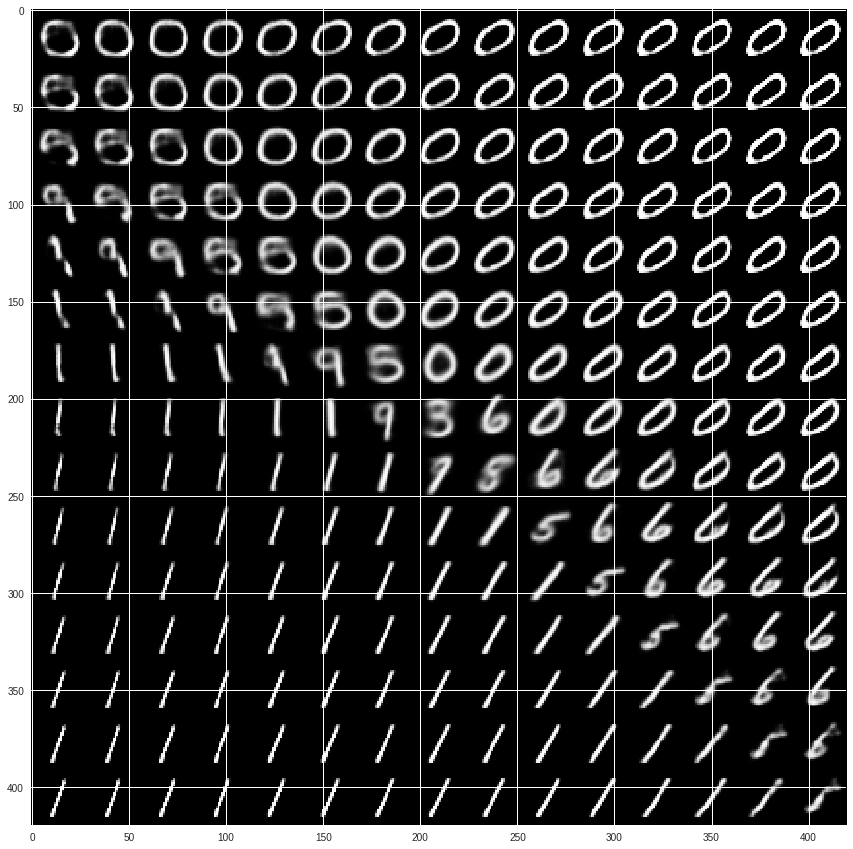

In [7]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([xi, yi])
        digit = laplaceVAE.generate_img(z_sample)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='Greys_r')
plt.show()

The images are much sharper than in case of Gaussian distribution, which can be thanks to the longer tail of the distribution. 

## Bernoulli distribution

What happens if discrete distributions are used? Try Bernoulli out, I thought it may be possible to learn the most describing probabilities of the numbers. So the proportional distribution is Bernoulli with 0.5 parameter, because every number occurs equal times in the dataset.

Here the main problem is sampling from the distribution: It is not possible to derive it, so the encoder doesn't learn anything, that is why the VAE wouldn't use the latent representation. I've run into this problem...

The solution is using tanh function instead of sign function. If it is steep enough then it is close to the sign. This cheat makes it working. 
The other hack is creating the Bernoulli from uniform distribution, here pops up the sign function.

In [14]:
latent_dim = 10
def sampling_bernoulli(z_theta):
    samples = K.random_uniform(shape=(K.shape(z_theta)[0], latent_dim) , minval=0.0, maxval=1.0)
    return (K.tanh((z_theta-samples)*5)+1) * 0.5  #sign is replaced with tanh, fontos a deriválhatóság miatt
    
bernoulli_params = {'theta': 'sigmoid'}

def KLdivergence_bernoulli(args):
  theta = args['theta']
  bern_q = K.ones(shape=(K.shape(theta)[0], latent_dim)) * 0.5
  return metrics.binary_crossentropy(theta,bern_q) * latent_dim

bernoulliVAE = VAE(sampling_bernoulli, bernoulli_params, KLdivergence_bernoulli)
bernoulliVAE.train()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Output "conv2d_25" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_25" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 28s 470us/step - loss: 189.2181 - val_loss: 168.5975
Epoch 2/10
19712/60000 [========>.....................] - ETA: 17s - loss: 165.8454

60000/60000 [==============================] - 27s 457us/step - loss: 162.8520 - val_loss: 155.5151
Epoch 3/10
54144/60000 [==========================>...] - ETA: 2s - loss: 156.0322

60000/60000 [==============================] - 27s 457us/step - loss: 155.6630 - val_loss: 152.0309
Epoch 4/10
60000/60000 [==============================] - 28s 459us/step - loss: 152.0283 - val_loss: 151.1939
Epoch 5/10
 4736/60000 [=>............................] - ETA: 24s - loss: 150.1005

60000/60000 [==============================] - 27s 458us/step - loss: 150.2333 - val_loss: 149.3167
Epoch 6/10
48256/60000 [=======================>......] - ETA: 5s - loss: 148.9772

60000/60000 [==============================] - 27s 457us/step - loss: 148.9227 - val_loss: 147.1886
Epoch 7/10
60000/60000 [==============================] - 27s 457us/step - loss: 148.3549 - val_loss: 146.9341
Epoch 8/10
 3328/60000 [>.............................] - ETA: 24s - loss: 147.7657

60000/60000 [==============================] - 27s 458us/step - loss: 147.5168 - val_loss: 147.6630
Epoch 9/10
47744/60000 [======================>.......] - ETA: 5s - loss: 146.9034

60000/60000 [==============================] - 28s 459us/step - loss: 146.8560 - val_loss: 145.6575
Epoch 10/10
60000/60000 [==============================] - 27s 458us/step - loss: 146.3047 - val_loss: 147.7405


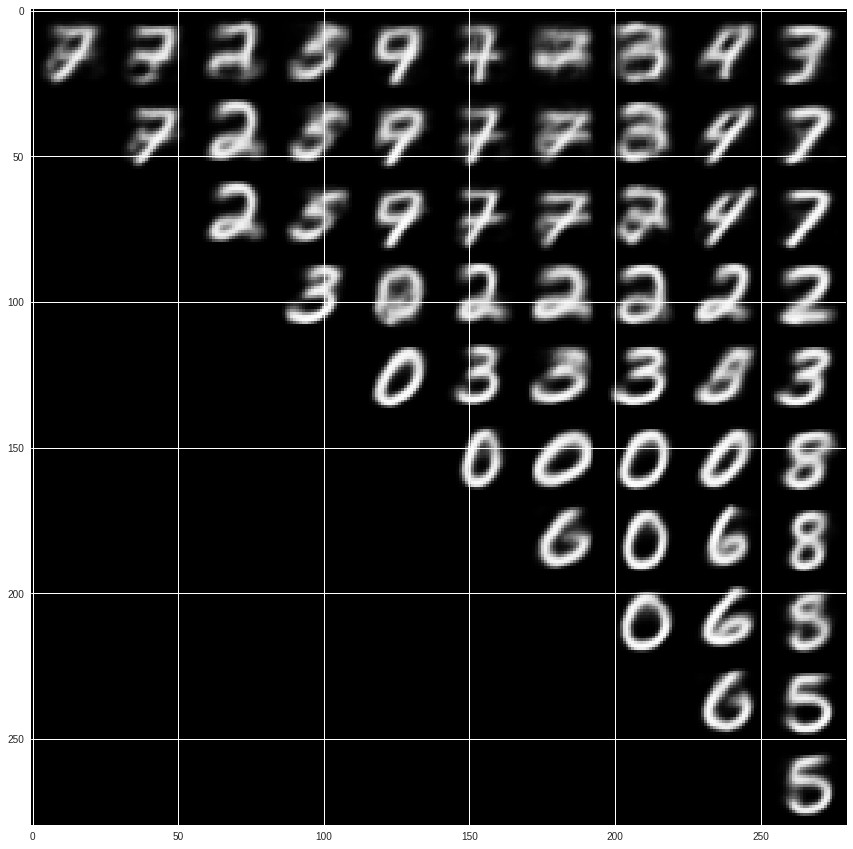

In [15]:
visualization_count=10
figure = np.zeros((digit_size * visualization_count, digit_size * visualization_count))
for i in range(visualization_count):
  for j in range(i,visualization_count):
    
        z_sample =np.concatenate((np.ones(i),np.zeros(latent_dim-i)))
        z_sample[j] = 1
        digit = bernoulliVAE.generate_img(z_sample)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='Greys_r')
plt.show()

The visualization shows  10 dimensional bernoulli distribution, each column shows if the given column number value in the latent vector is swithced to one. The row number shows the first n-1 element is one. The not mentioned part of the representation is zero.

The learned elements are surprisingly clear, considering the fact only 1024 possible state are existing to represent the images. 

## Categorical distribution

The idea in this case is learning to cluster the numbers, it is known 10 clusters exist, and each number occurs with p=1/10 probability.
Here comes the first problem, somehow, the VAE doesn't use the latent variable with this latent dimension. If the latent variable's dimension is too low, it doesn't contain enough information for the decoder and optimizes only for the mean of the images.

The sign function here also can be problematic and the sampling method is a bit more problematic in this case.

The training is very sensitive, it requires the right initialization to converge.

In [16]:
latent_dim = 20
def sampling_categorical(theta):
  cummulated_prob = K.cumsum(theta[0], axis=-1)
  sampled = K.random_uniform(shape=(K.shape(theta[0])[0],1) , minval=0.0, maxval=1.0)
  temp =((K.tanh((cummulated_prob-sampled)*10)+1)* 0.5) #zero the elements before the choosen index
  temp2 = K.concatenate([K.zeros(shape=(K.shape(temp)[0], 1)), temp[:,:-1]], axis=-1) #shift the vector by one.
  one_hot = temp-temp2
  return one_hot

    
categorical_params = {'theta': 'softmax'}

def KLdivergence_categorical(args):
  theta = args['theta']
  uniform_categories = K.ones(shape=(K.shape(theta)[0], latent_dim)) *(1.0/latent_dim)
  return metrics.categorical_crossentropy(theta,uniform_categories) 

categoricalVAE = VAE(sampling_categorical, categorical_params, KLdivergence_categorical)
categoricalVAE.train()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Output "conv2d_30" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_30" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 28s 473us/step - loss: 186.6216 - val_loss: 168.7471
Epoch 2/10
19712/60000 [========>.....................] - ETA: 17s - loss: 166.3854

60000/60000 [==============================] - 28s 460us/step - loss: 162.4073 - val_loss: 156.0373
Epoch 3/10
54144/60000 [==========================>...] - ETA: 2s - loss: 152.3576

60000/60000 [==============================] - 28s 460us/step - loss: 151.7893 - val_loss: 144.0123
Epoch 4/10
60000/60000 [==============================] - 28s 461us/step - loss: 141.3877 - val_loss: 134.5892
Epoch 5/10
 4736/60000 [=>............................] - ETA: 24s - loss: 136.7533

60000/60000 [==============================] - 28s 460us/step - loss: 134.2836 - val_loss: 136.2712
Epoch 6/10
48256/60000 [=======================>......] - ETA: 5s - loss: 130.1746

60000/60000 [==============================] - 28s 460us/step - loss: 129.8622 - val_loss: 128.7916
Epoch 7/10
60000/60000 [==============================] - 28s 461us/step - loss: 126.7183 - val_loss: 123.2119
Epoch 8/10
 3328/60000 [>.............................] - ETA: 24s - loss: 124.3073

60000/60000 [==============================] - 28s 459us/step - loss: 124.2656 - val_loss: 124.3341
Epoch 9/10
47744/60000 [======================>.......] - ETA: 5s - loss: 122.4398

60000/60000 [==============================] - 28s 460us/step - loss: 122.1907 - val_loss: 121.4143
Epoch 10/10
60000/60000 [==============================] - 28s 461us/step - loss: 120.4972 - val_loss: 120.5893


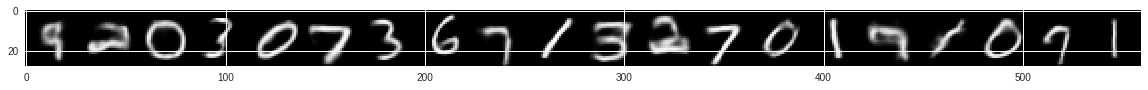

In [17]:
figure = np.zeros((digit_size, digit_size * latent_dim))

for i in range(latent_dim):
    
        z_sample =np.zeros(latent_dim)
        z_sample[i] = 1
        digit = categoricalVAE.generate_img(z_sample)
        figure[:,i * digit_size: (i + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
plt.show()

The 20 clusters: the images are clear and it is interesting how to differentiate the same number's different writing mode from each other.


In [18]:
if K.image_data_format() == 'channels_first':
      original_img_size = (img_chns, img_rows, img_cols)
else:
      original_img_size = (img_rows, img_cols, img_chns)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

pred_train = np.argmax(categoricalVAE.get_latent_representation(x_train), axis=-1)
print("Rand Score on train set: ",adjusted_rand_score(pred_train, y_train))

pred_test = np.argmax(categoricalVAE.get_latent_representation(x_test), axis=-1)
print("Rand Score on test set: ", adjusted_rand_score(pred_test, y_test))

Rand Score on train set:  0.06779262228083908
Rand Score on test set:  0.06919967132088257


Checking the clustering capabilities: Rand Score is used to see how well it learned the right classes.  Not so well, a human would use different clustering :(